In [31]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [2]:
train = pd.read_csv("train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Lendo e analisando o formato dos dados

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### Tirando as colunas que contém pouca interferência e passando os dados de nominais para numéricos : 

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
col = ['PassengerId', 'Name', 'Ticket', 'Cabin']
train = train.loc[:, ~train.columns.isin(col)]

In [8]:
train.loc[:, 'Sex'] = train.loc[:, 'Sex'].replace({'male' : 1, 'female' : 0})
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,S
1,1,1,0,38.0,1,0,71.2833,C
2,1,3,0,26.0,0,0,7.9250,S
3,1,1,0,35.0,1,0,53.1000,S
4,0,3,1,35.0,0,0,8.0500,S


In [9]:
# Fazendo o OneHotEncoder da classe Embarked.

encoded_df = pd.get_dummies(train['Embarked'], columns=['Embarked']).astype(int)

print(encoded_df.value_counts())

C  Q  S
0  0  1    644
1  0  0    168
0  1  0     77
   0  0      2
Name: count, dtype: int64


In [10]:
train.drop(columns = ['Embarked'], inplace = True)
train = pd.concat([train, encoded_df], axis = 1)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,0,3,1,22.0,1,0,7.2500,0,0,1
1,1,1,0,38.0,1,0,71.2833,1,0,0
2,1,3,0,26.0,0,0,7.9250,0,0,1
3,1,1,0,35.0,1,0,53.1000,0,0,1
4,0,3,1,35.0,0,0,8.0500,0,0,1


#### Preenchendo os valores NaN com o algoritmo KNN Imputer, usando o MinMax para normalizar os dados :

In [11]:
train.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
C             0
Q             0
S             0
dtype: int64

In [12]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,0,3,1,22.0,1,0,7.2500,0,0,1
1,1,1,0,38.0,1,0,71.2833,1,0,0
2,1,3,0,26.0,0,0,7.9250,0,0,1
3,1,1,0,35.0,1,0,53.1000,0,0,1
4,0,3,1,35.0,0,0,8.0500,0,0,1


In [13]:
# Usando o KNN inputer para preencher os valores não nulos.

imputer = KNNImputer(n_neighbors = 5)
train = pd.DataFrame(imputer.fit_transform(train), columns = train.columns).astype(float)
train.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
C           0
Q           0
S           0
dtype: int64

In [14]:
# Escalonando os dados com MinMaxScaler : 
#scaler = MinMaxScaler()
#x = scaler.fit_transform(train.loc[:, ~train.columns.isin(['Survived'])])
#y = train.loc[:, 'Survived']

In [15]:
# Escalonando os dados com o StandardScaler : 

scaler = StandardScaler()
x = scaler.fit_transform(train.loc[:, ~train.columns.isin(['Survived'])])
y = train.loc[:, 'Survived']

In [16]:
np.unique(y, return_counts = True)

(array([0., 1.]), array([549, 342]))

In [17]:
data_norm = pd.DataFrame(np.column_stack((y, x)), columns = train.columns)

data_norm.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,0.0,0.827377,0.737695,-0.587949,0.432793,-0.473674,-0.502445,-0.482043,-0.307562,0.619306
1,1.0,-1.566107,-1.355574,0.582260,0.432793,-0.473674,0.786845,2.074505,-0.307562,-1.614710
2,1.0,0.827377,-1.355574,-0.295397,-0.474545,-0.473674,-0.488854,-0.482043,-0.307562,0.619306
3,1.0,-1.566107,-1.355574,0.362846,0.432793,-0.473674,0.420730,-0.482043,-0.307562,0.619306
4,0.0,0.827377,0.737695,0.362846,-0.474545,-0.473674,-0.486337,-0.482043,-0.307562,0.619306


#### Criando os modelos de classificação que irão atuar sobre os dados de treino : 

#### Primeiro serão as duas arquiteturas de MLP's, porém com otimizadores diferentes : 

In [18]:
%%time

# Criando o modelo classificador com o otimizador ADAM : 

mlp_with_adam = MLPClassifier(activation = 'logistic', 
                    solver = 'adam', max_iter = 800)

n_neurons = [
    (i, j) for i in range(1, 10) for j in range(1, 5)
] + [
    (i, j, k) for i in range(1, 10) for j in range(1, 10) for k in range(1, 5)
]


parameters = {'hidden_layer_sizes': n_neurons}

mlp_adam_clf = GridSearchCV(estimator = mlp_with_adam, param_grid = parameters, cv = 10, scoring='accuracy').fit(x, y)

bparam_adam = mlp_adam_clf.best_params_['hidden_layer_sizes']
print(f"The best param is {bparam_adam} and the accuracy is : {mlp_adam_clf.best_score_}")

The best param is (9, 4) and the accuracy is : 0.8036079900124843
CPU times: user 25min 20s, sys: 299 ms, total: 25min 20s
Wall time: 25min 20s


In [19]:
%%time
# Fazendo um loop para pegar a acurácia média do classificador : 

result_ml_adam = list()

mlp_adam = MLPClassifier(hidden_layer_sizes=bparam_adam, activation = 'logistic', 
                         solver = 'adam', max_iter = 800)


for i in range(10):
    x, y = shuffle(x, y, random_state = 42)
    result_ml_adam.append(np.mean(cross_val_score(mlp_adam, x, y, cv = 10)))

result_ml_adam = np.array(result_ml_adam)
print(f"The accuracy for mlp is {np.mean(result_ml_adam)} +- {statistics.stdev(result_ml_adam)}")

The accuracy for mlp is 0.7966267166042447 +- 0.008418423869588434
CPU times: user 47.5 s, sys: 10 µs, total: 47.5 s
Wall time: 47.5 s


In [20]:
# Pegando os dados para a curva AUC gerada pelo modelo bayesiano : 

y_pred_proba_adam = mlp_adam.fit(x, y).predict_proba(x)[:, 1]

fpr_adam, tpr_adam, thresholds_adam = metrics.roc_curve(y,  y_pred_proba_adam)
auc_adam = metrics.roc_auc_score(y, y_pred_proba_adam)

print(f"The AUC value for the mlp using adam is : {auc_adam}")

The AUC value for the mlp using adam is : 0.8695182096102431


In [21]:
%%time
# Agora, realizando o treinamento para a rede MLP com o otimizador do gradiente estocástico.

mlp_with_sgd = MLPClassifier(activation = 'logistic', 
                             solver = 'sgd', max_iter = 800)


parameters = {'hidden_layer_sizes': n_neurons}

mlp_sgd_clf = GridSearchCV(estimator = mlp_with_sgd, param_grid = parameters, cv = 10, scoring='accuracy').fit(x,y)

bparam_sgd = mlp_sgd_clf.best_params_['hidden_layer_sizes']
print(f"The best param is {bparam_sgd} and the accuracy is : {mlp_sgd_clf.best_score_}")

The best param is (1, 1) and the accuracy is : 0.616167290886392
CPU times: user 5min 5s, sys: 16 ms, total: 5min 5s
Wall time: 5min 5s


In [22]:
%%time

# Fazendo um loop para pegar a acurácia média do classificador : 

result_ml_sgd = list()

mlp_sgd = MLPClassifier(hidden_layer_sizes = bparam_sgd, activation = 'logistic', 
                    solver = 'sgd', max_iter = 800)


for i in range(10):
    x, y = shuffle(x, y, random_state = 42)
    result_ml_sgd.append(np.mean(cross_val_score(mlp_sgd, x, y, cv = 10)))

result_ml_sgd = np.array(result_ml_sgd)
print(f"The accuracy for mlp using sgd is {np.mean(result_ml_sgd)} +- {statistics.stdev(result_ml_sgd)}")

The accuracy for mlp using sgd is 0.616167290886392 +- 0.0
CPU times: user 7.35 s, sys: 1e+03 ns, total: 7.35 s
Wall time: 7.35 s


In [23]:
# Pegando os dados para a curva AUC gerada pelo modelo bayesiano : 

y_pred_proba_sgd = mlp_sgd.fit(x, y).predict_proba(x)[:, 1]

fpr_sgd, tpr_sgd, thresholds_sgd = metrics.roc_curve(y,  y_pred_proba_sgd)
auc_sgd = metrics.roc_auc_score(y, y_pred_proba_sgd)

print(f"The AUC value for the mlp using sgd is : {auc_sgd}")

The AUC value for the mlp using sgd is : 0.7411295390875487


#### Criando o KNN classifier : 

In [24]:
%%time

neigh = KNeighborsClassifier()

n_neighbors = np.arange(start = 1, stop = 50, step = 1)
parameters = {'n_neighbors': n_neighbors}

knn_clf = GridSearchCV(estimator = neigh, param_grid = parameters, cv = 10).fit(x, y)

bparam_knn = knn_clf.best_params_['n_neighbors']
print(f"The best param is {bparam_knn} and the accuracy is : {knn_clf.best_score_}")

The best param is 7 and the accuracy is : 0.8192634207240947
CPU times: user 2.31 s, sys: 8 ms, total: 2.32 s
Wall time: 2.32 s


In [25]:
%%time

# Fazendo um loop para pegar a acurácia média do classificador : 

result_knn = list()

knn_blam = KNeighborsClassifier(n_neighbors = bparam_knn)

for i in range(10):
    x, y = shuffle(x, y, random_state = 42)
    result_knn.append(np.mean(cross_val_score(knn_blam, x, y, cv = 10)))

result_knn = np.array(result_knn)
print(f"The accuracy for KNN is {np.mean(result_knn)} +- {statistics.stdev(result_knn)}")

The accuracy for KNN is 0.8149350811485642 +- 0.004162829780313139
CPU times: user 462 ms, sys: 3.99 ms, total: 466 ms
Wall time: 465 ms


In [26]:
# Pegando os dados para a curva AUC gerada pelo modelo knn : 

y_pred_proba_knn = knn_blam.fit(x, y).predict_proba(x)[:, 1]

fpr_knn, tpr_knn, thresholds_knn = metrics.roc_curve(y,  y_pred_proba_knn)
auc_knn = metrics.roc_auc_score(y, y_pred_proba_knn)

print(f"The AUC value for the knn is : {auc_knn}")

The AUC value for the knn is : 0.9269644968523312


#### Criando o Bayesian classifier : 

In [27]:
%%time

# Realizando o treino do classificador bayesiano : 

result_bay = list()

bay = GaussianNB().fit(x, y)
np.mean(cross_val_score(bay, x, y, cv = 10))

for i in range(10):
    x, y = shuffle(x, y, random_state = 42)
    result_bay.append(np.mean(cross_val_score(bay, x, y, cv = 10)))
                      
result_bay = np.array(result_bay)
print(f"The accuracy for mlp is {np.mean(result_bay)} +- {statistics.stdev(result_bay)}")

The accuracy for mlp is 0.782474406991261 +- 0.0031656785713506733
CPU times: user 153 ms, sys: 4 ms, total: 157 ms
Wall time: 156 ms


In [28]:
# Pegando os dados para a curva AUC gerada pelo modelo bayesiano : 

y_pred_proba_bay = bay.predict_proba(x)[:, 1]

fpr_bay, tpr_bay, thresholds_bay = metrics.roc_curve(y,  y_pred_proba_bay)
auc_bay = metrics.roc_auc_score(y, y_pred_proba_bay)

print(f"The AUC value for the bayes classifier is : {auc_bay}")

The AUC value for the bayes classifier is : 0.8291950276419648


#### Comparando todas as curvas AUC's geradas por cada classificador : 

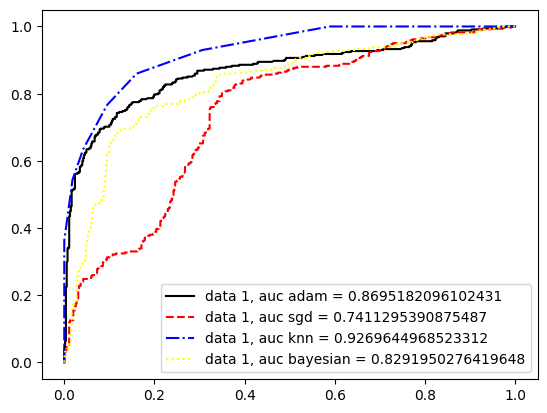

In [29]:
plt.plot(fpr_adam, tpr_adam, label="data 1, auc adam = "+str(auc_adam), linestyle = '-', color = 'black')
plt.legend(loc=4)

plt.plot(fpr_sgd, tpr_sgd, label="data 1, auc sgd = "+str(auc_sgd), linestyle = '--', color = 'red')
plt.legend(loc=4)

plt.plot(fpr_knn, tpr_knn, label="data 1, auc knn = "+str(auc_knn), linestyle = '-.', color = 'blue')
plt.legend(loc=4)

plt.plot(fpr_bay, tpr_bay, label="data 1, auc bayesian = "+str(auc_bay), linestyle = ':', color = 'yellow')
plt.legend(loc=4)

plt.show()

Optimal Threshold: inf
Maximum Accuracy: 0.6161616161616161


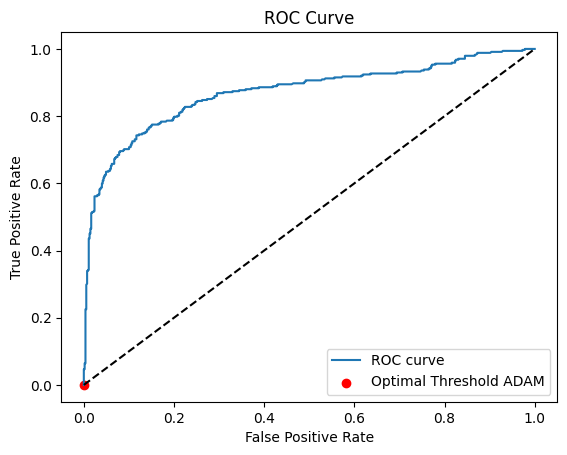

In [32]:
# Compute accuracy for each threshold
import sys
accuracies_adam = list()
#rint(mlp_adam.predict(test))
#y_pred = (y_pred_proba_adam >= 0.5).astype(int)

#print(y_pred)
#print(accuracy_score(y,y_pred))

for threshold in thresholds_adam:
    y_pred = (y_pred_proba_adam >= threshold).astype(int)
    accuracies_adam.append(accuracy_score(y, y_pred))
    #print(accuracy_score(y, y_pred), threshold)
    #print(y_pred)

# Find the threshold with the maximum accuracy
max_acc_adam_idx = np.argmax(accuracies_adam)
opt_thresh_adam = thresholds_adam[max_acc_adam_idx]
max_accuracy_adam = accuracies_adam[max_acc_adam_idx]


print(f'Optimal Threshold: {opt_thresh_adam}')
print(f'Maximum Accuracy: {max_accuracy_adam}')


plt.figure()
plt.plot(fpr_adam, tpr_adam, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.scatter(fpr_adam[max_acc_adam_idx], tpr_adam[max_acc_adam_idx], color='red', label='Optimal Threshold ADAM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

Optimal Threshold: inf
Maximum Accuracy: 0.6161616161616161


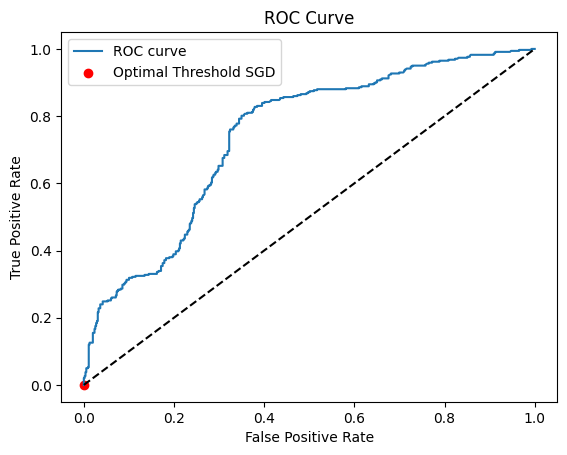

In [33]:
# Compute accuracy for each threshold
accuracies_sgd = list()
for threshold in thresholds_sgd:
    y_pred = (y_pred_proba_adam >= threshold).astype(int)
    accuracies_sgd.append(accuracy_score(y, y_pred))

# Find the threshold with the maximum accuracy
max_acc_sgd_idx = np.argmax(accuracies_sgd)
opt_thresh_sgd = thresholds_sgd[max_acc_sgd_idx]
max_accuracy_sgd = accuracies_sgd[max_acc_sgd_idx]


print(f'Optimal Threshold: {opt_thresh_sgd}')
print(f'Maximum Accuracy: {max_accuracy_sgd}')


plt.figure()
plt.plot(fpr_sgd, tpr_sgd, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.scatter(fpr_sgd[max_acc_sgd_idx], tpr_sgd[max_acc_sgd_idx], color='red', label='Optimal Threshold SGD')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

#### Tratando os dados de teste : 

In [34]:
test = pd.read_csv("test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [35]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [36]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [37]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [38]:
PassengerId = test['PassengerId']
col = ['PassengerId', 'Name', 'Ticket', 'Cabin']
test = test.loc[:, ~test.columns.isin(col)]

In [39]:
test.loc[:, 'Sex'] = test.loc[:, 'Sex'].replace({'male' : 1, 'female' : 0})
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.5,0,0,7.8292,Q
1,3,0,47.0,1,0,7.0000,S
2,2,1,62.0,0,0,9.6875,Q
3,3,1,27.0,0,0,8.6625,S
4,3,0,22.0,1,1,12.2875,S


In [40]:
# Realizando o Encoder das variáveis categóricas de teste : 

encoded_df = pd.get_dummies(test['Embarked'], columns=['Embarked']).astype(int)

print(encoded_df.value_counts())

C  Q  S
0  0  1    270
1  0  0    102
0  1  0     46
Name: count, dtype: int64


In [41]:
test.drop(columns = ['Embarked'], inplace = True)
test = pd.concat([test, encoded_df], axis = 1)
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,3,1,34.5,0,0,7.8292,0,1,0
1,3,0,47.0,1,0,7.0000,0,0,1
2,2,1,62.0,0,0,9.6875,0,1,0
3,3,1,27.0,0,0,8.6625,0,0,1
4,3,0,22.0,1,1,12.2875,0,0,1


#### Usando o KNN imputer : 

In [42]:
# O KNN já foi definido no código acima, apenas iremos reutilizá-lo : 

test = pd.DataFrame(imputer.fit_transform(test), columns = test.columns)
test = test.astype(float)
test.isna().sum()

Pclass    0
Sex       0
Age       0
SibSp     0
Parch     0
Fare      0
C         0
Q         0
S         0
dtype: int64

#### Usando MinMax scaler para modificar os dados : 

In [43]:
#scaler = MinMaxScaler()

#test_norm = scaler.fit_transform(test)
#test_norm = pd.DataFrame(test_norm, columns=test.columns)
#test_norm.head()

In [44]:
# Escalonando os dados com o StandardScaler : 

scaler = StandardScaler()
test_norm = scaler.fit_transform(test)
test_norm = pd.DataFrame(test_norm, columns=test.columns)
test_norm.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,0.873482,0.755929,0.332234,-0.499470,-0.400248,-0.497562,-0.568142,2.843757,-1.350676
1,0.873482,-1.322876,1.295315,0.616992,-0.400248,-0.512427,-0.568142,-0.351647,0.740370
2,-0.315819,0.755929,2.451013,-0.499470,-0.400248,-0.464248,-0.568142,2.843757,-1.350676
3,0.873482,0.755929,-0.245615,-0.499470,-0.400248,-0.482623,-0.568142,-0.351647,0.740370
4,0.873482,-1.322876,-0.630848,0.616992,0.619896,-0.417637,-0.568142,-0.351647,0.740370


#### Usando os modelos para prever sobre os dados de teste : 

In [45]:
pred = mlp_adam.predict_proba(test)[:, 1]
pred = (pred >= opt_thresh_adam).astype(int)


pred_arr = np.column_stack((PassengerId, pred))

# Create the DataFrame
predictions_df = pd.DataFrame(pred_arr, columns=['PassengerId', 'Survived']).astype(int)
predictions_df.to_csv('predictions.csv', index=False)

In [46]:
np.unique(pred, return_counts=True)

(array([0]), array([418]))

In [47]:
pred = pd.read_csv('predictions.csv')
pred.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [48]:
pred['Survived'].value_counts()

Survived
0    418
Name: count, dtype: int64

In [49]:
pred_adam = mlp_adam.predict(test)
np.unique(pred_adam, return_counts=True)

(array([0.]), array([418]))

In [50]:
pred_sgd = mlp_sgd.predict(test)
np.unique(pred_sgd, return_counts=True)

(array([0.]), array([418]))